# Mushroom Type Classification with fastai 

<div style="text-align:center">
<div><img style="width:400px" src="https://i.pinimg.com/originals/9b/ed/89/9bed89fee3e35c30bbc30f9e9d82b859.jpg"></img><div>
<div style="margin-bottom:20px; color:rgb(117, 117, 117);font-size:12px;">Source: https://www.pinterest.com/pin/597641813035305267/</div>
</div>

## Background

In US alone, around 7500 yearly cases of mushrooms poisoning are reported [(Source)](https://www.tandfonline.com/doi/full/10.1080/00275514.2018.1479561). According to the source, "misidentification of edible mushroom species appears to be the most common cause and may be preventable through education". 

The goal of this project is to try to create a machine learning model, that can recognize mushroom types. This type of model could help people make the right choice when mushroom picking. 

This project was made using a [Kaggle dataset](https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images).

---

## Project

### 1. Load data and EDA

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import fastai
import torch
from torchvision import models
from torchvision import transforms
from fastai.vision.all import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

We're going to load the data with [ImageDataLoader](https://docs.fast.ai/vision.data.html#ImageDataLoaders.from_folder) and explore it with some EDA. For data augmentation we're going to use the [aug_transforms](https://docs.fast.ai/vision.augment.html#aug_transforms) function that provides a collection of data augmentation transforms with defaults that perform well on many datasets. 

In [2]:
train_dataloader = ImageDataLoaders.from_folder(
    path="./images/Mushrooms",
    valid_pct=0.2,
    bs=32,
    num_workers=0,
    seed=0,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms()
)

In [3]:
print("Number of items in the validation set: ", len(train_dataloader.valid.items))
print("Number of items in the training set: ", len(train_dataloader.train.items))

Number of items in the validation set:  1342
Number of items in the training set:  5372


In [4]:
train_dataloader.vocab

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']

As we can see there are 9 different classes of mushrooms. Let's see how many samples of each class we have.

In [5]:
mushroom_type_counts = {}
path = "./images/Mushrooms"
for species in os.listdir(path):
    img_list = os.listdir(f'{path}/{species}')
    img_count = len(img_list)
    mushroom_type_counts[species] = img_count

In [6]:
mushroom_type_counts_sorted = dict(sorted(mushroom_type_counts.items(), key=lambda x: x[1]))
mushroom_type_counts_sorted

{'Suillus': 311,
 'Hygrocybe': 316,
 'Agaricus': 353,
 'Entoloma': 364,
 'Amanita': 750,
 'Cortinarius': 836,
 'Boletus': 1073,
 'Russula': 1148,
 'Lactarius': 1563}

[Text(0.5, 0, 'Mushroom Type'), Text(0, 0.5, 'Count')]

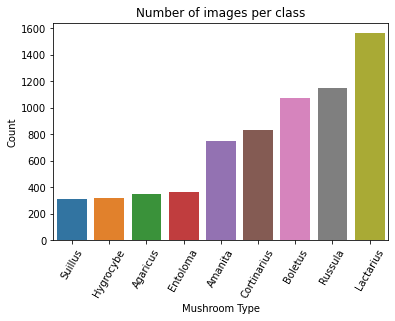

In [16]:
keys = list(mushroom_type_counts_sorted.keys())
vals = list(mushroom_type_counts_sorted.values())
ax = sns.barplot(x=keys, y=vals)
_ = plt.xticks(rotation = 60)
ax.set_title('Number of images per class')
ax.set(xlabel="Mushroom Type", ylabel = "Count")

As we can see, there is a class imbalance.
* Lactarius class has the most images (1563)
* Suillus (311) and Hygrocybe (316) have the least samples.

Let's look at some of the images from each class.

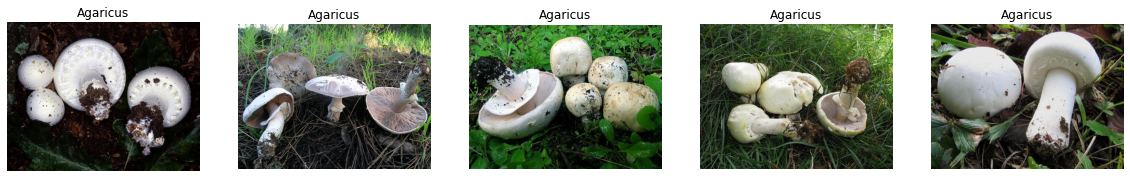

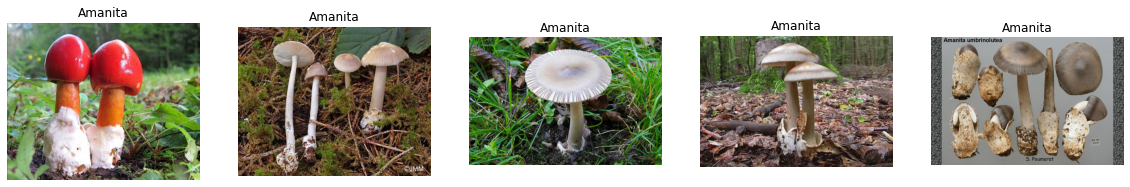

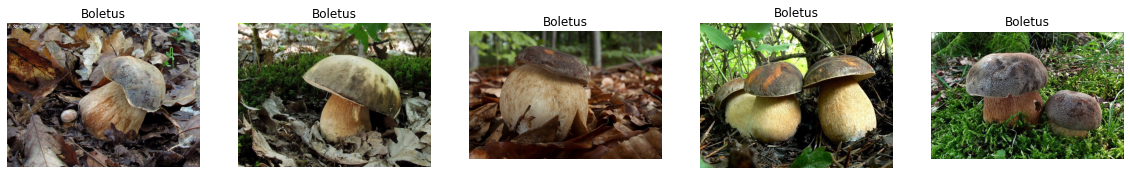

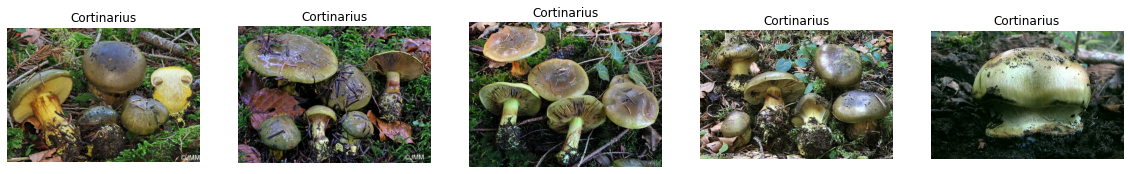

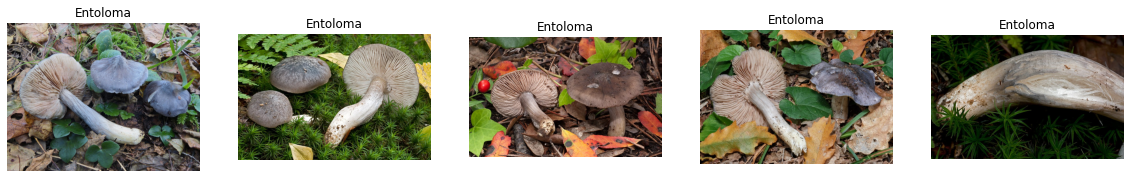

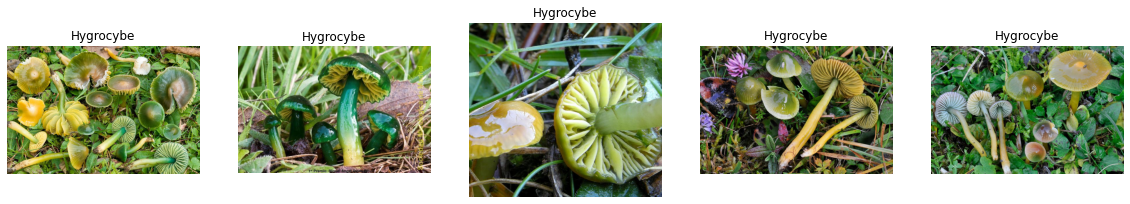

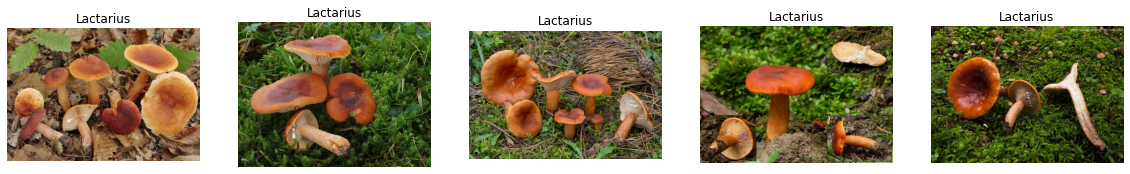

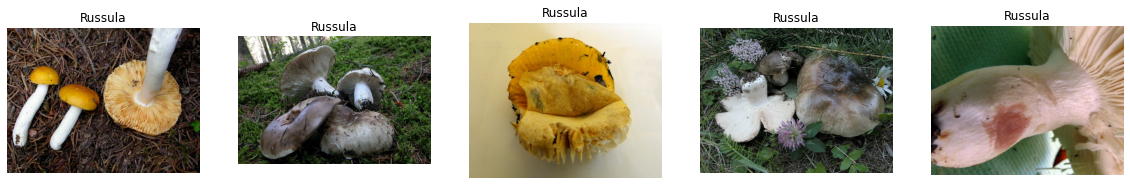

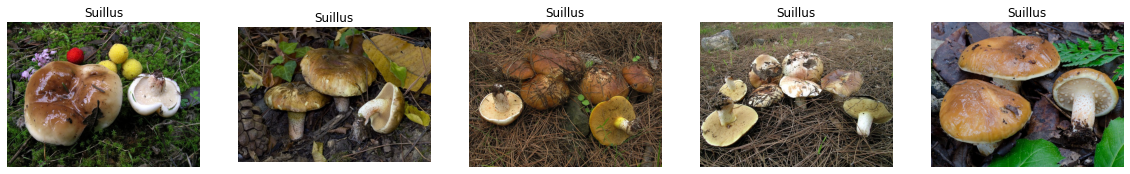

In [17]:
for folder in os.listdir(path):
    plt.figure(figsize=(20, 8))
    for i, file in enumerate(os.listdir(f'{path}/{folder}')[0:5]):
        img = np.asarray(Image.open(f'{path}/{folder}/{file}', 'r'))
        plt.subplot(1, 5, i + 1)
        plt.axis('off')
        plt.grid(b=None)
        plt.title(folder)
        plt.imshow(img)

### 2. Modeling

It's time for training. We are going to use the pre trained model resnet34 which was pretrained on the ImageNet dataset and Adam optimization function. Let's build a convnet style learner with [cnn_learner](https://docs.fast.ai/vision.learner.html#cnn_learner) function, use the learning rate finder to find the best learning rate and fine tune the pre trained model on our task.

In [6]:
learn = cnn_learner(train_dataloader, resnet34, metrics=accuracy, path=".", opt_func=Adam)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.005248074419796467)

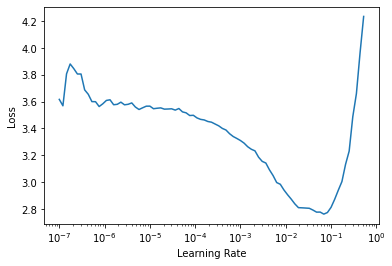

In [22]:
learn.lr_find()

In [23]:
learn.fine_tune(5, 0.007)

As we can see, after fine tuning for 5 epochs we get 90% accuracy.

In [24]:
learn.save('model')

Path('models/model.pth')

In [7]:
learn.load('model')

### 3. Evaluate the model

Now let's evaluate the model's performance. First, let's see measure the inference speed. We are going to do this by measuring how long it takes to make one prediction. Then, we're going to look at some of the predictions.

In [11]:
%%time
learn.predict(train_dataloader.valid.items[0])

Wall time: 100 ms


('Lactarius',
 tensor(6),
 tensor([3.3444e-07, 4.9544e-07, 8.3092e-05, 7.7006e-06, 1.3173e-06, 1.0268e-06,
         9.9828e-01, 1.3728e-03, 2.5334e-04]))

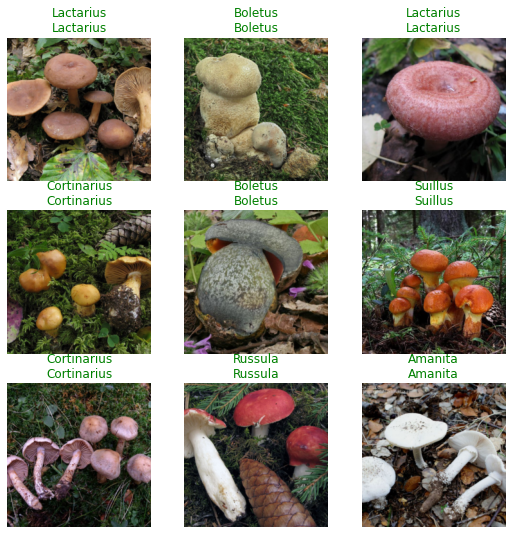

In [10]:
learn.show_results()

As we can see, all of the predictions were correct for this batch. However, to get a better understanding of our model's accuracy we should look at the confusion matrix.

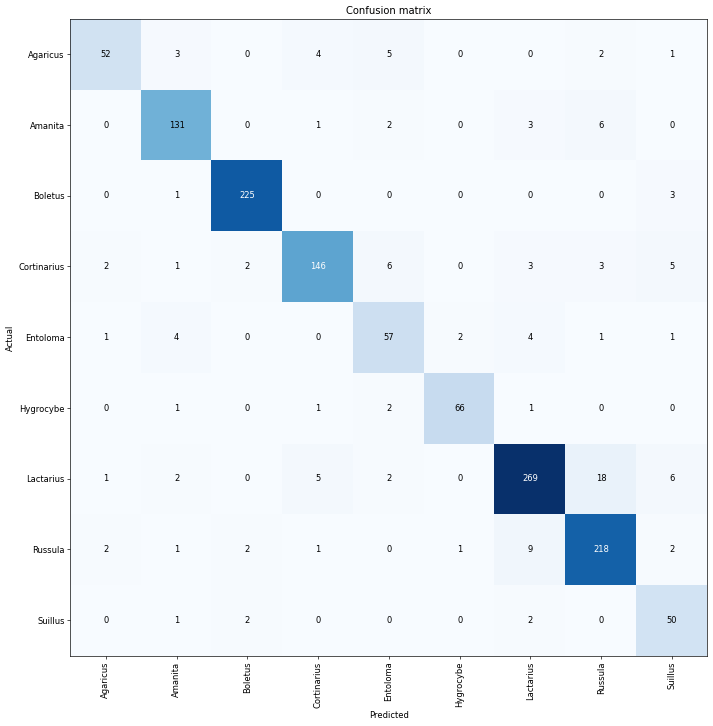

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Overall, most classes have been predicted correctly. Some classes have Let's see which classes caused the most confusion.

In [29]:
interp.most_confused(min_val=4)

[('Lactarius', 'Russula', 18),
 ('Russula', 'Lactarius', 9),
 ('Amanita', 'Russula', 6),
 ('Cortinarius', 'Entoloma', 6),
 ('Lactarius', 'Suillus', 6),
 ('Agaricus', 'Entoloma', 5),
 ('Cortinarius', 'Suillus', 5),
 ('Lactarius', 'Cortinarius', 5),
 ('Agaricus', 'Cortinarius', 4),
 ('Entoloma', 'Amanita', 4),
 ('Entoloma', 'Lactarius', 4)]

As we can see, there were 18 images where Lactarius was confused for Russula and 9 images where Russula was confused for Lactarius. Next, let's plot the top losses.

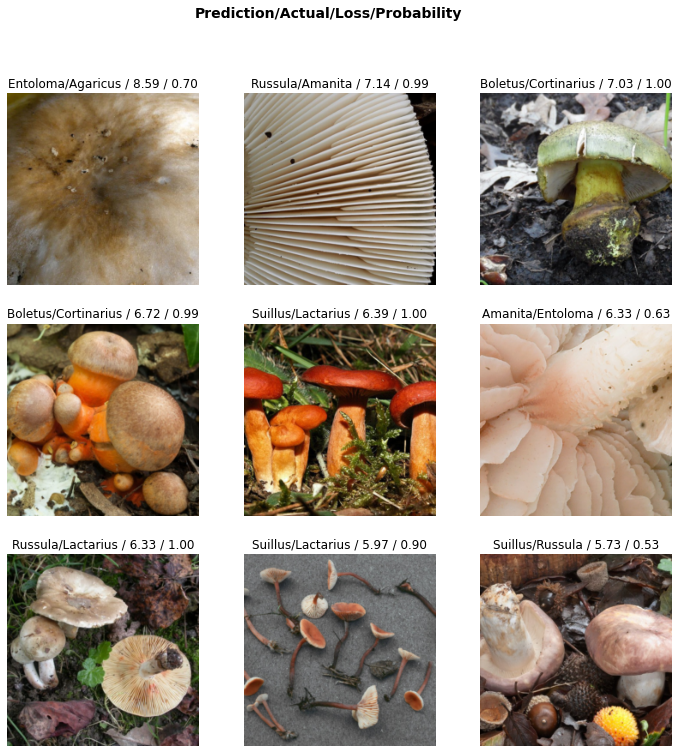

In [30]:
interp.plot_top_losses(9, figsize=(12,12))

## Bonus (different optimizer) 

For the bonus challenge let's try using a different optimizer(SGD). The rest of the process is the same.

In [20]:
learn_sgd = cnn_learner(train_dataloader, resnet34, metrics=accuracy, path=".", opt_func=SGD)

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=6.309573450380412e-07)

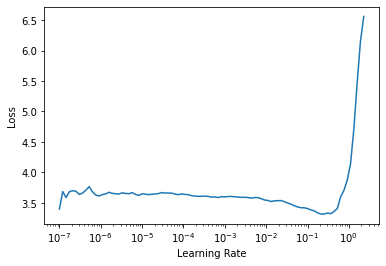

In [34]:
learn_sgd.lr_find()

In [35]:
learn_sgd.fine_tune(5, 0.025)

As we can see, this time the accuracy isn't as good.

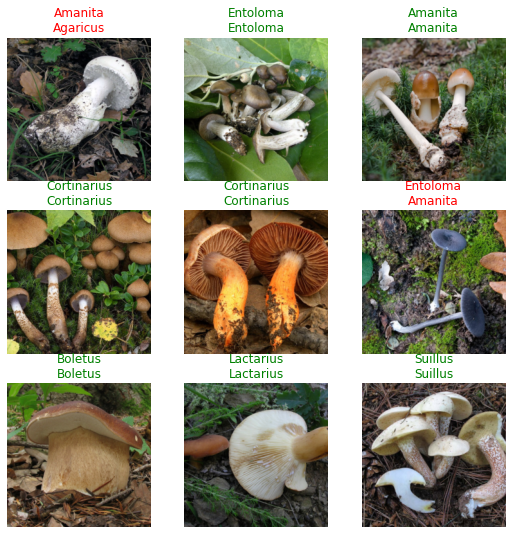

In [36]:
learn_sgd.show_results()

In [37]:
learn.save('model_sgd')

Path('models/model_sgd.pth')

In [21]:
learn.load('model_sgd')